In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sports-classification/EfficientNetB0-100-(224 X 224)- 98.40.h5
/kaggle/input/sports-classification/sports.csv
/kaggle/input/sports-classification/valid/bobsled/5.jpg
/kaggle/input/sports-classification/valid/bobsled/1.jpg
/kaggle/input/sports-classification/valid/bobsled/4.jpg
/kaggle/input/sports-classification/valid/bobsled/3.jpg
/kaggle/input/sports-classification/valid/bobsled/2.jpg
/kaggle/input/sports-classification/valid/hurdles/5.jpg
/kaggle/input/sports-classification/valid/hurdles/1.jpg
/kaggle/input/sports-classification/valid/hurdles/4.jpg
/kaggle/input/sports-classification/valid/hurdles/3.jpg
/kaggle/input/sports-classification/valid/hurdles/2.jpg
/kaggle/input/sports-classification/valid/snow boarding/5.jpg
/kaggle/input/sports-classification/valid/snow boarding/1.jpg
/kaggle/input/sports-classification/valid/snow boarding/4.jpg
/kaggle/input/sports-classification/valid/snow boarding/3.jpg
/kaggle/input/sports-classification/valid/snow boarding/2.jpg
/kaggl

In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import os 
import sys
import cv2
import torch 
import torch.nn as nn
from tqdm import tqdm
import torch.optim as optim
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor

In [3]:
data_dirname = '../input/sports-classification'
print(os.listdir(data_dirname))

['EfficientNetB0-100-(224 X 224)- 98.40.h5', 'sports.csv', 'valid', 'test', 'train']


In [4]:
classes = os.listdir(data_dirname + '/train')
print("Number of sports:", len(classes))
print("\nList of sports:\n", classes)

Number of sports: 100

List of sports:
 ['bobsled', 'hurdles', 'snow boarding', 'fly fishing', 'luge', 'sidecar racing', 'ampute football', 'volleyball', 'billiards', 'giant slalom', 'tennis', 'horse racing', 'pole dancing', 'figure skating women', 'rollerblade racing', 'fencing', 'olympic wrestling', 'golf', 'ultimate', 'harness racing', 'football', 'frisbee', 'bungee jumping', 'shot put', 'ice climbing', 'figure skating men', 'rowing', 'bike polo', 'swimming', 'judo', 'axe throwing', 'archery', 'baseball', 'wheelchair basketball', 'log rolling', 'lacrosse', 'rock climbing', 'horse jumping', 'hydroplane racing', 'formula 1 racing', 'curling', 'jousting', 'javelin', 'water cycling', 'speed skating', 'barell racing', 'bull riding', 'horseshoe pitching', 'croquet', 'chuckwagon racing', 'hammer throw', 'rugby', 'pole climbing', 'nascar racing', 'snowmobile racing', 'boxing', 'mushing', 'track bicycle', 'canoe slamon', 'disc golf', 'bmx', 'air hockey', 'rings', 'trapeze', 'motorcycle racin

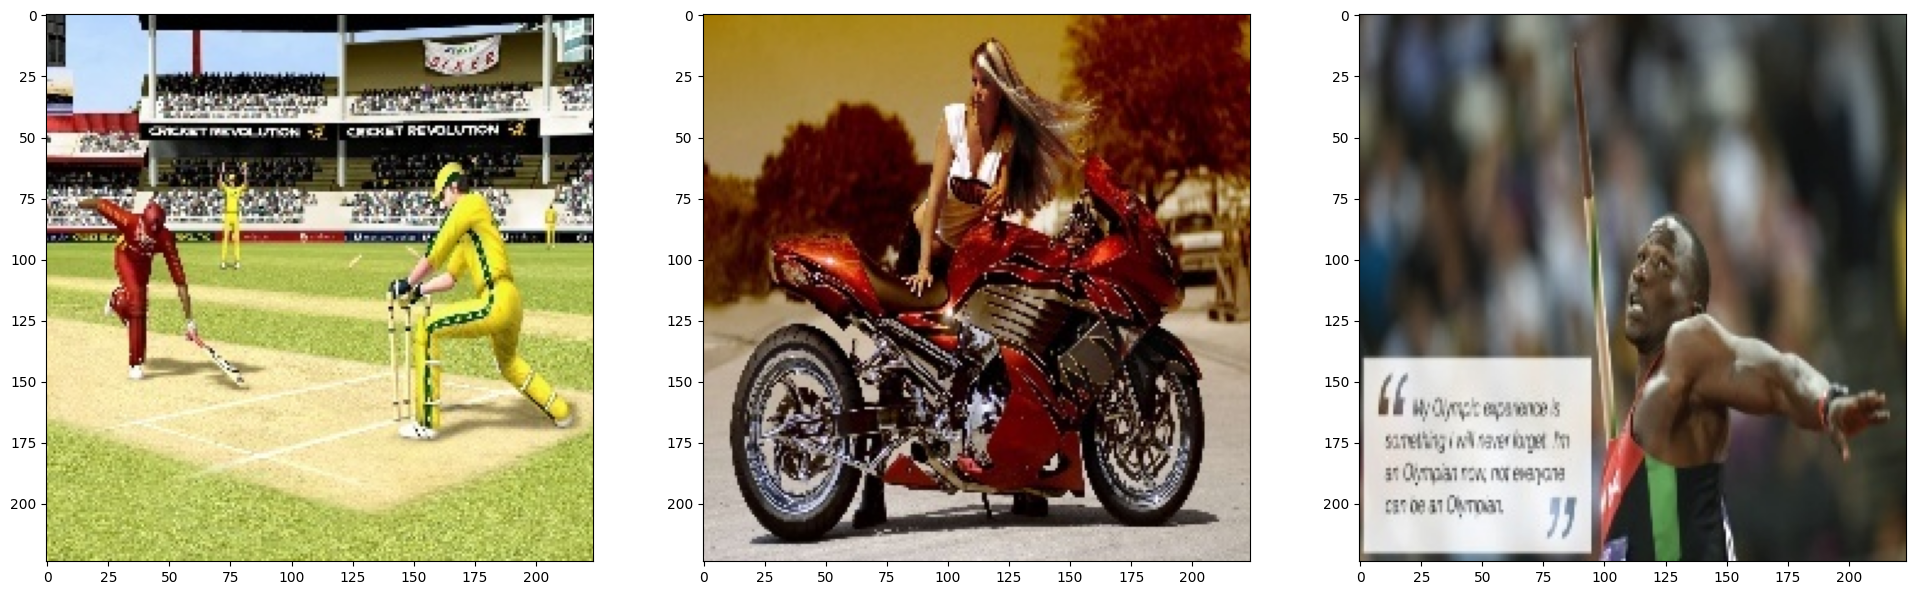

In [5]:
img_pth = []
num = 3
img_pth.append(data_dirname + '/train/cricket/001.jpg')
img_pth.append(data_dirname + '/train/motorcycle racing/001.jpg')
img_pth.append(data_dirname + '/train/javelin/004.jpg')

images = [cv2.imread(img_pth[i]) for i in range(num)]
rgb_images = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in images]

fig, ax = plt.subplots(1, 3, figsize = (24, 24))
for i, img in enumerate(rgb_images): 
    ax[i].imshow(img)

In [6]:
import os
import pandas as pd

class ImageFolderToDataFrame:
    def __init__(self, train_data_dir, test_data_dir=None):
        self.train_data_dir = train_data_dir
        self.test_data_dir = test_data_dir

    def convert_to_dataframe(self):
        def process_folder(folder_path, label):
            image_paths = [os.path.join(folder_path, img) for img in os.listdir(folder_path) if img.endswith('.jpg')]
            labels = [label] * len(image_paths)
            return pd.DataFrame({'image_path': image_paths, 'label': labels})

        train_classes = os.listdir(os.path.join(self.train_data_dir, 'train'))
        train_dfs = [process_folder(os.path.join(self.train_data_dir, 'train', class_name), class_name) for class_name in train_classes]
        train_df = pd.concat(train_dfs, ignore_index=True)

        test_df = None
        if self.test_data_dir:
            test_classes = os.listdir(os.path.join(self.test_data_dir, 'test'))
            test_dfs = [process_folder(os.path.join(self.test_data_dir, 'test', class_name), class_name) for class_name in test_classes]
            test_df = pd.concat(test_dfs, ignore_index=True)

        return train_df, test_df

train_data_dir = data_dirname
test_data_dir = data_dirname 

image_folder_converter = ImageFolderToDataFrame(train_data_dir, test_data_dir)
training_df, testing_df = image_folder_converter.convert_to_dataframe()

print("Training DataFrame:")
print(training_df.head())

if testing_df is not None:
    print("\nTesting DataFrame:")
    print(testing_df.head())


Training DataFrame:
                                          image_path    label
0  ../input/sports-classification/train/bobsled/0...  bobsled
1  ../input/sports-classification/train/bobsled/0...  bobsled
2  ../input/sports-classification/train/bobsled/1...  bobsled
3  ../input/sports-classification/train/bobsled/0...  bobsled
4  ../input/sports-classification/train/bobsled/0...  bobsled

Testing DataFrame:
                                          image_path    label
0  ../input/sports-classification/test/bobsled/5.jpg  bobsled
1  ../input/sports-classification/test/bobsled/1.jpg  bobsled
2  ../input/sports-classification/test/bobsled/4.jpg  bobsled
3  ../input/sports-classification/test/bobsled/3.jpg  bobsled
4  ../input/sports-classification/test/bobsled/2.jpg  bobsled


In [ ]:
training_df.info()

In [ ]:
df = pd.read_csv(data_dirname + '/sports.csv')
df

In [ ]:
df.info()

In [ ]:
train_df = df.loc[df['data set'] == 'train']
train_df.head()

In [ ]:
valid_df = df.loc[df['data set'] == 'valid']
valid_df.head()

In [ ]:
test_df = df.loc[df['data set'] == 'test']
test_df.head()

In [ ]:
df.value_counts('labels').plot.barh(figsize=(10, 20))

In [11]:
input_shape = (224, 224)
num_labels = 100
workers = os.cpu_count()
batch_size = 64

In [7]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=(-15, 15)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5]
    )
])

valid_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5]
    )
])

Dataset ImageFolder
    Number of datapoints: 13492
    Root location: ../input/sports-classification/train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               RandomVerticalFlip(p=0.5)
               RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=0)
               ToTensor()
               Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
           )
Dataset ImageFolder
    Number of datapoints: 500
    Root location: ../input/sports-classification/valid
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
               Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
           )
Dataset ImageFolder
    Number of datapoints: 500
    Root location: ../input/sports-classification/test
    StandardT

In [9]:
print(len(train_dataset.classes), '\n', train_dataset.classes)

100 
 ['air hockey', 'ampute football', 'archery', 'arm wrestling', 'axe throwing', 'balance beam', 'barell racing', 'baseball', 'basketball', 'baton twirling', 'bike polo', 'billiards', 'bmx', 'bobsled', 'bowling', 'boxing', 'bull riding', 'bungee jumping', 'canoe slamon', 'cheerleading', 'chuckwagon racing', 'cricket', 'croquet', 'curling', 'disc golf', 'fencing', 'field hockey', 'figure skating men', 'figure skating pairs', 'figure skating women', 'fly fishing', 'football', 'formula 1 racing', 'frisbee', 'gaga', 'giant slalom', 'golf', 'hammer throw', 'hang gliding', 'harness racing', 'high jump', 'hockey', 'horse jumping', 'horse racing', 'horseshoe pitching', 'hurdles', 'hydroplane racing', 'ice climbing', 'ice yachting', 'jai alai', 'javelin', 'jousting', 'judo', 'lacrosse', 'log rolling', 'luge', 'motorcycle racing', 'mushing', 'nascar racing', 'olympic wrestling', 'parallel bar', 'pole climbing', 'pole dancing', 'pole vault', 'polo', 'pommel horse', 'rings', 'rock climbing', 'r

In [12]:
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    num_workers=workers,
    shuffle=True,
    drop_last=True,
)

valid_loader = DataLoader(
    valid_dataset,
    batch_size=batch_size,
    num_workers=workers,
    shuffle=False,
    drop_last=False,
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    num_workers=workers,
    shuffle=False,
    drop_last=False,
)

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.transforms import transforms
from torchvision.datasets import ImageFolder

input_shape = (224, 224)
num_labels = 100


class SimpleCNN(nn.Module):
    def __init__(self, num_classes=num_labels):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(256 * (input_shape[0] // 8) * (input_shape[1] // 8), 512)
        self.relu4 = nn.ReLU()
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.pool3(self.relu3(self.conv3(x)))
        x = self.flatten(x)
        x = self.relu4(self.fc1(x))
        x = self.fc2(x)
        return x

model = SimpleCNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        total_correct = 0
        total_samples = 0
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total_samples += labels.size(0)
            total_correct += (predicted == labels).sum().item()

    accuracy = total_correct / total_samples
    print(f"Epoch {epoch + 1}/{num_epochs}, Validation Accuracy: {accuracy:.4f}")

model.eval()
with torch.no_grad():
    total_correct = 0
    total_samples = 0
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total_samples += labels.size(0)
        total_correct += (predicted == labels).sum().item()

test_accuracy = total_correct / total_samples
print(f"Test Accuracy: {test_accuracy:.4f}")


Epoch 1/10, Validation Accuracy: 0.0380
Epoch 2/10, Validation Accuracy: 0.0580
Epoch 3/10, Validation Accuracy: 0.1100
Epoch 4/10, Validation Accuracy: 0.1780
Epoch 5/10, Validation Accuracy: 0.2720
Epoch 6/10, Validation Accuracy: 0.3080
Epoch 7/10, Validation Accuracy: 0.3660


KeyboardInterrupt: 

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=num_labels):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(256 * (input_shape[0] // 8) * (input_shape[1] // 8), 512)
        self.relu4 = nn.ReLU()
        self.fc2 = nn.Linear(512, num_classes)
        self.softmax = nn.Softmax(dim=1)  # Softmax activation for the output layer

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.pool3(self.relu3(self.conv3(x)))
        x = self.flatten(x)
        x = self.relu4(self.fc1(x))
        x = self.fc2(x)
        x = self.softmax(x)
        return x

model = SimpleCNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        total_correct = 0
        total_samples = 0
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total_samples += labels.size(0)
            total_correct += (predicted == labels).sum().item()

    accuracy = total_correct / total_samples
    print(f"Epoch {epoch + 1}/{num_epochs}, Validation Accuracy: {accuracy:.4f}")

model.eval()
with torch.no_grad():
    total_correct = 0
    total_samples = 0
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total_samples += labels.size(0)
        total_correct += (predicted == labels).sum().item()

test_accuracy = total_correct / total_samples
print(f"Test Accuracy: {test_accuracy:.4f}")

In [ ]:
def train_one_epoch(
    model: nn.Module,
    loader: DataLoader,
    criterion: nn.Module,
    optimizer: optim.Optimizer,
    device: str = "cpu",
    verbose: bool = True,
) -> dict:

    model.train()

    losses = []
    accuracies = []

    with tqdm(total=len(loader), desc="training", file=sys.stdout, ncols=100, disable=not verbose) as progress:
        for x_batch, y_true in loader:
            x_batch = x_batch.to(device)
            y_true = y_true.to(device)

            optimizer.zero_grad()
            y_pred = model(x_batch)
            loss = criterion(y_pred, y_true)
            
            loss.backward()

            losses.append(loss.item())
            accuracies.append((y_pred.argmax(1) == y_true).float().detach().cpu().numpy())

            progress.set_postfix_str(f"loss {losses[-1]:.4f}")

            optimizer.step()

            progress.update(1)

    logs = {
        "losses": np.array(losses),
        "accuracies": np.concatenate(accuracies)
    }

    return logs

In [ ]:
@torch.inference_mode()
def evaluate(
    model: nn.Module,
    loader: DataLoader,
    criterion: nn.Module,
    device: str = "cpu",
    verbose: bool = True,
) -> dict:

    model.eval()

    losses = []
    accuracies = []

    for x_batch, y_true in tqdm(loader, desc="evaluation", file=sys.stdout, ncols=100, disable=not verbose):
        x_batch = x_batch.to(device)
        y_true = y_true.to(device)

        # forward pass
        y_pred = model(x_batch)
        # calculate the loss
        loss = criterion(y_pred, y_true)

        losses.append(loss.item())
        accuracies.append((y_pred.argmax(1) == y_true).float().detach().cpu().numpy())

    logs = {
        "losses": np.array(losses),
        "accuracies": np.concatenate(accuracies)
    }

    return logs

In [ ]:
def save_model(file_name, epoch, n_epochs, model, optimizer, train_loss, train_accuracy, valid_loss, valid_accuracy):

    checkpoint = {
                 "model_state_dict": model.state_dict(),
                 "optimizer_state_dict": optimizer.state_dict(),
                 "epoch": epoch,
                 "num_epochs": n_epochs,
                 "metrics": {
                    "training": {"loss": train_loss, "accuracy": train_accuracy},
                    "validation": {"loss": valid_loss, "accuracy": valid_accuracy},
                 },
    }
    torch.save(checkpoint, f'/kaggle/working/{file_name}')

In [ ]:
def models_competition(model_name: str, model, train_loader, valid_loader, loss_fn, optimizer, device):

    n_epochs = 20

    train_losses, train_accuracies = [], []
    valid_losses, valid_accuracies = [], []
    
    best_score = float("-inf")

    for ep in range(n_epochs):
        print(f"\nEpoch {ep + 1:2d}/{n_epochs:2d}")

        train_logs = train_one_epoch(model, train_loader, loss_fn, optimizer, device, verbose=True)
        train_losses.append(np.mean(train_logs["losses"]))
        train_accuracies.append(np.mean(train_logs["accuracies"]))
        print("      loss:", train_losses[-1])
        print("  accuracy:", train_accuracies[-1])


        valid_logs = evaluate(model, valid_loader, loss_fn, device, verbose=True)
        valid_losses.append(np.mean(valid_logs["losses"]))
        valid_accuracies.append(np.mean(valid_logs["accuracies"]))
        print("      loss:", valid_losses[-1])
        print("  accuracy:", valid_accuracies[-1])
        
        scheduler.step(valid_losses[-1])
        
        file_name = f'best_{model_name}.pth'
        if valid_accuracies[-1] >= best_score:
            save_model(file_name, ep + 1, n_epochs, model, optimizer, train_losses[-1], train_accuracies[-1], valid_losses[-1], valid_accuracies[-1])
            best_score = valid_accuracies[-1]

    return train_losses, train_accuracies, valid_losses, valid_accuracies

In [ ]:
def visualize_results(train_losses, train_accuracies, valid_losses, valid_accuracies):

    fix, axes = plt.subplots(ncols=2, figsize=(15, 4))

    axes[0].plot(np.arange(len(train_losses)), train_losses, ".-")
    axes[0].plot(np.arange(len(valid_losses)), valid_losses, ".-")
    axes[0].legend(["train", "validation"])
    axes[0].set_title("Loss")
    axes[0].grid()

    axes[1].plot(np.arange(len(train_accuracies)), train_accuracies, ".-")
    axes[1].plot(np.arange(len(valid_accuracies)), valid_accuracies, ".-")
    axes[1].legend(["train", "validation"])
    axes[1].set_title("Accuracy")
    axes[1].grid();

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device - {device}\n")

In [ ]:
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
torch.manual_seed(42)
model.fc = nn.Linear(model.fc.in_features, num_labels)
model = model.to(device)
print("Number of trainable parameters -", sum(p.numel() for p in model.parameters() if p.requires_grad))

optimizer = optim.Adam(model.parameters(), lr=1e-4)

loss_fn = nn.CrossEntropyLoss()

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.1, patience=3, verbose=True)

train_losses, train_accuracies, valid_losses, valid_accuracies = models_competition('resnet18', model, train_loader, valid_loader, loss_fn, optimizer, device)